In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Lab_4_data_fitting.ipynb")

# Lab week 4: Data fitting to see if we can detect a grasp success y/n

Can you use the finger 1 stop time and max value to tell the difference between a successful and a failed grasp?

Lab slides: https://docs.google.com/presentation/d/1NtoXYbl2nq1dkIU0KQE8ogjSCfb22wgLigY3JJpHHGI/edit?usp=sharing


In [2]:
# Install a pip package in the current Jupyter kernel
# Note: this is a safety check in case your JN install was not in the same place as your libraries
import sys
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Doing the imports for you
import numpy as np
import json as json
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial

## Read the data in 

In [4]:
# TODO: Read the same data in as for the lecture activity and put it in the data_motor_position variable and make
#   your ts values

time_step = 1/30


data_motor_position = np.loadtxt('Data/Motor position f1.csv', dtype='float', delimiter=',') # Motor position f1.csv
ts = np.arange(data_motor_position.shape[1])/30

# 

In [5]:
grader.check("Read data")

Read data results: All test cases passed!

## Box plot of fitted lines for all data

In the lecture activity you fit a line to just one row (each) of the successful versus failed grasps. In this lab you'll fit the line to ALL of the grasps. For each grasp, save the end point (time at the **y_max** value and the **y_max** value and the error of the fit). You'll be making a box plot of this data to see if either look different for successful versus failed grasps.

Why a box plot? Box plots are better for visually showing multiple distributions in the same plot, where they can be compared side-by-side.

See lab slides for what this should look like when you're done.

In [7]:
# TODO: Copy over fit_line_to_middle from the lecture activity
def fit_line_to_middle_bit(ts, ys, eps=1e-2):
    """ Fit a line to the sloped middle bit of the data
      Return the line as a pair of points, one where the fitted line crosses the y min value, one where the line crosses
      the y max value (see slides for picture)
    @param ts - the time values for the data (x-axis)
    @param ys - the function values (y-axis)
    @param eps - a fudge factor for clipping the middle bit (min + eps and max - eps)
    @returns (x_min, y_min), (x_max, y_max), std_err  (two tuples and the error of the fit)"""


    # TODO: 
    #.  Get y min and y max from the data
    #.  Use np.where to find the indices of the points that are between
    #.    ymin + eps * (ymax - ymin) and ymax - eps * (ymax - ymin)
    #   Get out just the data between those two indices (remember that 3:5 gets items 3 and 4, but not 5, use 3:6 to get 3,4,5)
    #.  Do a linear regression on just that data
    #.  Use the fitted line to get out the corresponding x values for y max and y min
    #.   x = (y - intercept) / slope
    #  Note: Use y_max and y_min, not the y values from the array, to find the x values
    y_min = np.min(ys)
    y_max = np.max(ys)

    # find high and low indices
    low = y_min+eps*(y_max-y_min)
    high = y_max-eps*(y_max-y_min)

    # find middle indice
    middle = np.where((ys >= low)&(ys <= high))

    # find ts, ys middle
    ts_middle = ts[middle]
    ys_middle = ys[middle]

    # calculate slope, intercept, standard error
    slope, intercept, _, _, std_err = linregress(ts_middle, ys_middle)

    err_fit = std_err

    # find x min and max
    x_min = (y_min-intercept)/slope
    x_max = (y_max-intercept)/slope

    return (x_min, y_min), (x_max, y_max), err_fit

In [9]:
# TEST CELL
# TODO: Check that it works
rows_to_use = (22, 445)
fit_line_to_middle_bit(ts = ts, ys = data_motor_position[rows_to_use[0], :], eps = 1e-2)


((np.float64(0.2330073115337753), np.float64(179.9599915)),
 (np.float64(0.46405870605229665), np.float64(329.6480103)),
 np.float64(1.8290933731414798))

In [10]:
# EXAMPLE CODE
# This bit of code shows how to do the nx2 array part

# Make the nx2 array - one row for each element
np_array_for_res = np.zeros((data_motor_position.shape[0], 2))
# For each row
for row in range(0, data_motor_position.shape[0]):
    # Put the min value in the first column, the max in the second
    np_array_for_res[row, 0] = np.min(data_motor_position[row, :])    
    np_array_for_res[row, 1] = np.max(data_motor_position[row, :])

    # This also works
    min_value = np.min(data_motor_position[row, :]) 
    max_value = np.max(data_motor_position[row, :])
    np_array_for_res[row, :] = [min_value, max_value]

print(np_array_for_res)

[[299.9920044 429.8800049]
 [299.9920044 429.7919922]
 [299.9920044 429.8800049]
 ...
 [299.9920044 429.8800049]
 [299.9920044 429.9679871]
 [179.9599915 329.9119873]]


In [22]:
def fit_middle_all(ts, data):
    """ Fit the middle for every row of data
    @param ts - the t values to use
    @param data - n picks X timesteps
    @returns all end times, max values, and errors as one numpy array (n rows X 3)"""


    # TODO:
    #.    make numpy array to put data in (nx3)
    #.    for each row in data
    #.       start_pt, end_pt, err_fit = fit_line_to_middle_bit(ts, current row)
    #        copy end_pt and err_fit information into appropriate row in nx3 output
    #. return nx3 numpy array
    # create nx3 array
    data_array = np.zeros((data.shape[0], 3))
    # loop for number of rows in array
    for r in range(data_array.shape[0]):
        start_pt, end_pt, err_fit = fit_line_to_middle_bit(ts = ts, ys = data[r, :], eps = 1e-2)
        data_array[r, 0] = end_pt[0]
        data_array[r, 1] = end_pt[1]
        data_array[r, 2] = err_fit
    
    return data_array


In [23]:
# TEST CELL
# Write the code to call the function here

# The successful rows go from 0 to 354
last_row_successful = 355

# The unsuccessful rows are the remaining ones


# TODO:
#. Call your function twice, once with the successful data, once with the failed
fit_data_successful = fit_middle_all(ts = ts, data = data_motor_position[0:355, :])
fit_data_failed = fit_middle_all(ts = ts, data = data_motor_position[355:, :])

# Note for both of these: Small changes in how you index can result in slightly different numbers,
#  but the overall magnitude should be correct

# Note: Doing np.mean(nx3 array, 0) tells numpy to do the mean over each column (instead of the mean
#  over the entire nx3 array). So it should return 3 numbers - the mean of the times, the mean
#  of the max y values, and the mean of the fit error

# Should print the following, although the actual decimal places may differ
#  Mean successful [3.98791579e-01 4.07402569e+02 4.21582062e+00] and failed [  0.40810473 392.76044707   5.51566179]
print(f"Mean successful {np.mean(fit_data_successful, 0)} and failed {np.mean(fit_data_failed, 0)}")

Mean successful [3.98791579e-01 4.07402569e+02 4.21582062e+00] and failed [  0.40810473 392.76044707   5.51566179]


In [24]:
grader.check("Fitted_line_code")

Fitted_line_code results: All test cases passed!

<!-- BEGIN QUESTION -->

## Do the box plots

- Left window: t values of y_max point (the first column of fit_data_*)

- Middle window: y_max values (the second column of fit_data_*)

- Right window: fit error values (the third column of fit_data_*)

Note that boxplot uses labels for labeling the x axis of the box plot.

Implementation order: for plotting, try calling box plot with just one column of data. Then add the second. 

/tmp/ipykernel_11143/1894983198.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([fit_data_successful[:, 0], fit_data_failed[:, 0]], labels =['Succ', 'Fail'])
/tmp/ipykernel_11143/1894983198.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([fit_data_successful[:, 1], fit_data_failed[:, 1]], labels =['Succ', 'Fail'])
/tmp/ipykernel_11143/1894983198.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[2].boxplot([fit_data_successful[:, 2], fit_data_failed[:, 2]], labels =['Succ', 'Fail'])


Text(0.5, 1.0, 'Fit err')

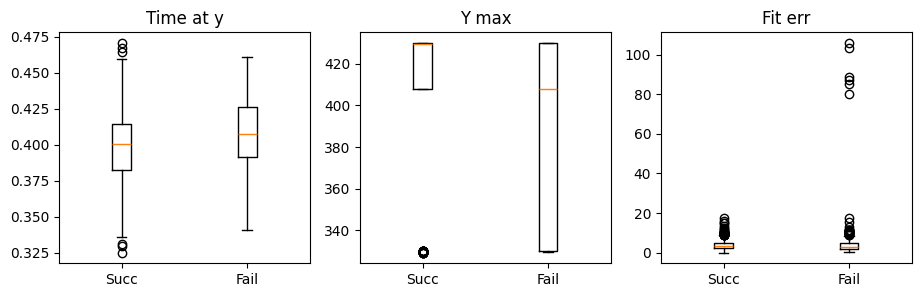

In [42]:
# Three plots
n_rows = 1
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 3))

# Do the box plots...

axs[0].boxplot([fit_data_successful[:, 0], fit_data_failed[:, 0]], labels =['Succ', 'Fail'])
axs[0].set_title('Time at y')

axs[1].boxplot([fit_data_successful[:, 1], fit_data_failed[:, 1]], labels =['Succ', 'Fail'])
axs[1].set_title('Y max')

axs[2].boxplot([fit_data_successful[:, 2], fit_data_failed[:, 2]], labels =['Succ', 'Fail'])
axs[2].set_title('Fit err')

In [43]:
# Manual grade
print("This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.")

This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.


<!-- END QUESTION -->

# Part 2: Fitting a curve to the wrist force data

## First step: Getting the data

Along with the motor data we also have force data at the wrist. The wrist force data has three channels (x,y,z). For this assignment, we want to get out the total magnitude of the force at the wrist, rather than the force in each direction individually:

Equation: **sqrt (sum x,y,z (wrist force data)^2)**

The data is stored in **Wrist_force_data.csv** in the Data directory. 

In [57]:

# TODO: Read in the data; should be 660 x 120 (x,y,z data for 40 time steps)
data_wrist_force_xyz = np.loadtxt('Data/Wrist_force_data.csv', dtype='float', delimiter=',')

In [71]:
# TODO: Calculate the total force (see equation above)

# TODO: Calculate the magnitude of the force
data_wrist_force_magnitude = np.sqrt(data_wrist_force_xyz[:, 0::3]**2 + data_wrist_force_xyz[:, 1::3]**2 + data_wrist_force_xyz[:, 2::3]**2)

assert data_wrist_force_magnitude.shape == (660, 40)
assert np.isclose(data_wrist_force_magnitude[0, 0], 6.5389367, atol=0.001)
assert np.isclose(np.max(data_wrist_force_magnitude), 20.46059305836466, atol=0.001)

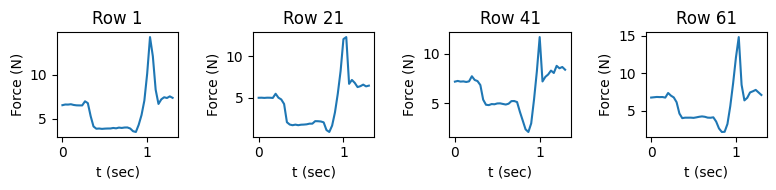

In [75]:
# Plot a few of the rows to see what the data looks like
n_rows = 1
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 2))


# TODO Pick 4 examples to plot. Use your ts values from above. You do not need to
#   use the ones from the slides, but you should but the example number in the title
# Don't forget to label the x and y axes
axs[0].plot(ts, data_wrist_force_magnitude[0, :])
axs[0].set_title('Row 1')
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('Force (N)')
axs[1].plot(ts, data_wrist_force_magnitude[20, :])
axs[1].set_title('Row 21')
axs[1].set_xlabel('t (sec)')
axs[1].set_ylabel('Force (N)')
axs[2].plot(ts, data_wrist_force_magnitude[40, :])
axs[2].set_title('Row 41')
axs[2].set_xlabel('t (sec)')
axs[2].set_ylabel('Force (N)')
axs[3].plot(ts, data_wrist_force_magnitude[60, :])
axs[3].set_title('Row 61')
axs[3].set_xlabel('t (sec)')
axs[3].set_ylabel('Force (N)')

plt.tight_layout()

In [76]:
grader.check("Fit_curve")

Fit_curve results: All test cases passed!

## Write a function to fit a polynomial to one row of the data

Since we aren't sure what a "good" polynomial fit might be, make that a parameter

In [81]:
def fit_poly(ts, data, deg):
    """ Fit a polynomial to the data
    @param ts - the x values
    @param data - the y values
    @param degree of the polynomial. Should be an integer
    @return a list of polynomial coefficients (see polynomial.polyfit)"""
    ret_poly = polynomial.polyfit(ts, data, deg) # Call polynomial.polyfit

    return ret_poly


In [82]:
# Test

check_poly = fit_poly(ts, data_wrist_force_magnitude[10], deg=2)


assert np.all(np.isclose(check_poly, [10.0970104, -13.91458045, 10.73089215], atol=0.01))

In [83]:
grader.check("fit_cubic")

fit_cubic results: All test cases passed!

<!-- BEGIN QUESTION -->

## Check the fit

It's not always clear what a "good" fit is. In this part of the code we'll plot a rset of examples, with increasing degrees of polynomials.

Sometimes you just want to plot some examples but don't really care which ones; this problem also has a solution to the "I have space for n plots, I want to skip over some of the data" problem

In [84]:
# EXAMPLE CODE - row column indexing, how to put n things into a grid

# If you have n things, and you want to put them in r rows, first figure out how many columns you'll need
#  Integer division: 
#    n // r  gives the number of times r can go into n
#    n % r gives the left over - it is always in the range 0 to n-1
n = 15
r = 4
c = n // r  # this gives the floor of n / r, which in this case will be 15/4 is 3
if n % r != 0:  # % is modulus - unless r goes exactly into n we need to add a bit (some of the last columns will be empty)
    c += 1   # Make c one bigger

# Go through all of n
for i in range(0, n):
    row = i // r   # Which row we're on
    col = i % r    # Which column we're on
    end_str = " "       # Use a space at the end of the pring
    if col == r-1:
        end_str = "\n"  # ... except at the end of the row
    print(f"n{i}r{row}c{col} ", end=end_str)  # No return


n0r0c0  n1r0c1  n2r0c2  n3r0c3 
n4r1c0  n5r1c1  n6r1c2  n7r1c3 
n8r2c0  n9r2c1  n10r2c2  n11r2c3 
n12r3c0  n13r3c1  n14r3c2  

In [85]:
# EXAMPLE CODE - zip
# These two pieces of code do the same thing
a_str = ("foo", "bar")
b_number = (3, 10)
for i in range(len(a_str)):
    a = a_str[i]
    b = b_number[i]
    print(f"Loop iteration {i} has {a} and {b}")

# Look, no i!
for a, b in zip(a_str, b_number):
    print(f"Loop iteration... um... has {a} and {b}")

Loop iteration 0 has foo and 3
Loop iteration 1 has bar and 10
Loop iteration... um... has foo and 3
Loop iteration... um... has bar and 10


In [ ]:
# SCRATCH CELL
# Practice the plot for one row of data

In [ ]:
# Note: This code will all work even if you change the number of rows/columns
n_rows = 4
n_cols = 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

n_total_plots = n_rows * n_cols
# take every nth
n_skip = data_wrist_force_magnitude.shape[0] // n_total_plots

color_deg = ("maroon", "steelblue", "olivedrab")
deg_fit = (1, 3, 6)
lstyle = ('dashed', 'dotted', 'dashdot')
# This loops over the total number of plots we can fit
for i in range(0, n_total_plots):
    # Yes, this works - it's the same as doing r = row_offset + p // ncols on one line,
    #   and c = p % n_cols on the second line
    r, c = i // n_cols, i % n_cols
    data_row_indx = i * n_skip

    # Plot 4 things in this figure:
    #   the original data (in black)
    #   polynomial fits of degree 1, 3, 6
    # Note: use axs[r, c]
    # Note 2: The data row you want is in data_row_indx...
    # Note 3: Use polynomial.polyval(ts, ret_poly) to create y values for your t values
    ...

plt.tight_layout()

In [ ]:
# Manual grade
print("This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.")

<!-- END QUESTION -->

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [ ]:

# List of names (creates a set)
worked_with_names = {"not filled out"}
# List of URLS I25 (creates a set)
websites = {"not filled out"}
# Approximate number of hours, including lab/in-class time
hours = -1.5

In [ ]:
grader.check("hours_collaborators")

### To submit

- Do a restart then run all to make sure everything runs ok and the plots are showing
- Save the file
- Submit just this .ipynb file through gradescope, Lab 4, fitting
- You do NOT need to submit the data files - we will supply those
- Where there are given variable/file names (eg, foo = ...) DON'T change those, or the autograder will fail

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Most likely failure for this assignment is not naming the data directory and files correctly; capitalization matters for the Gradescope grader. 

A gentle reminder that you should NOT be copying and pasting code (let alone sending files) to other people in the class.